# Paper Replicating - ViT

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.3.1+cu121
torchvision version: 0.18.1+cu121


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4177, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 4177 (delta 61), reused 105 (delta 39), pack-reused 4035 (from 1)
Receiving objects: 100% (4177/4177), 651.42 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (2433/2433), done.
Updating files: 100% (248/248), done.


### 1. Get Data

In [14]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [15]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### 2. Create Datasets and DataLoaders
Our transforms will reflect the data used in the paper: image size (224,224) and batch size = 4096. Since we'll be training our model from scratch (no transfer learning) we won't provide a `normalize` function

In [16]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x790474baee60>,
 ['pizza', 'steak', 'sushi'])

In [14]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

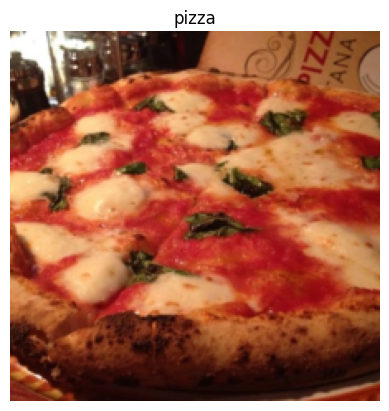

In [15]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

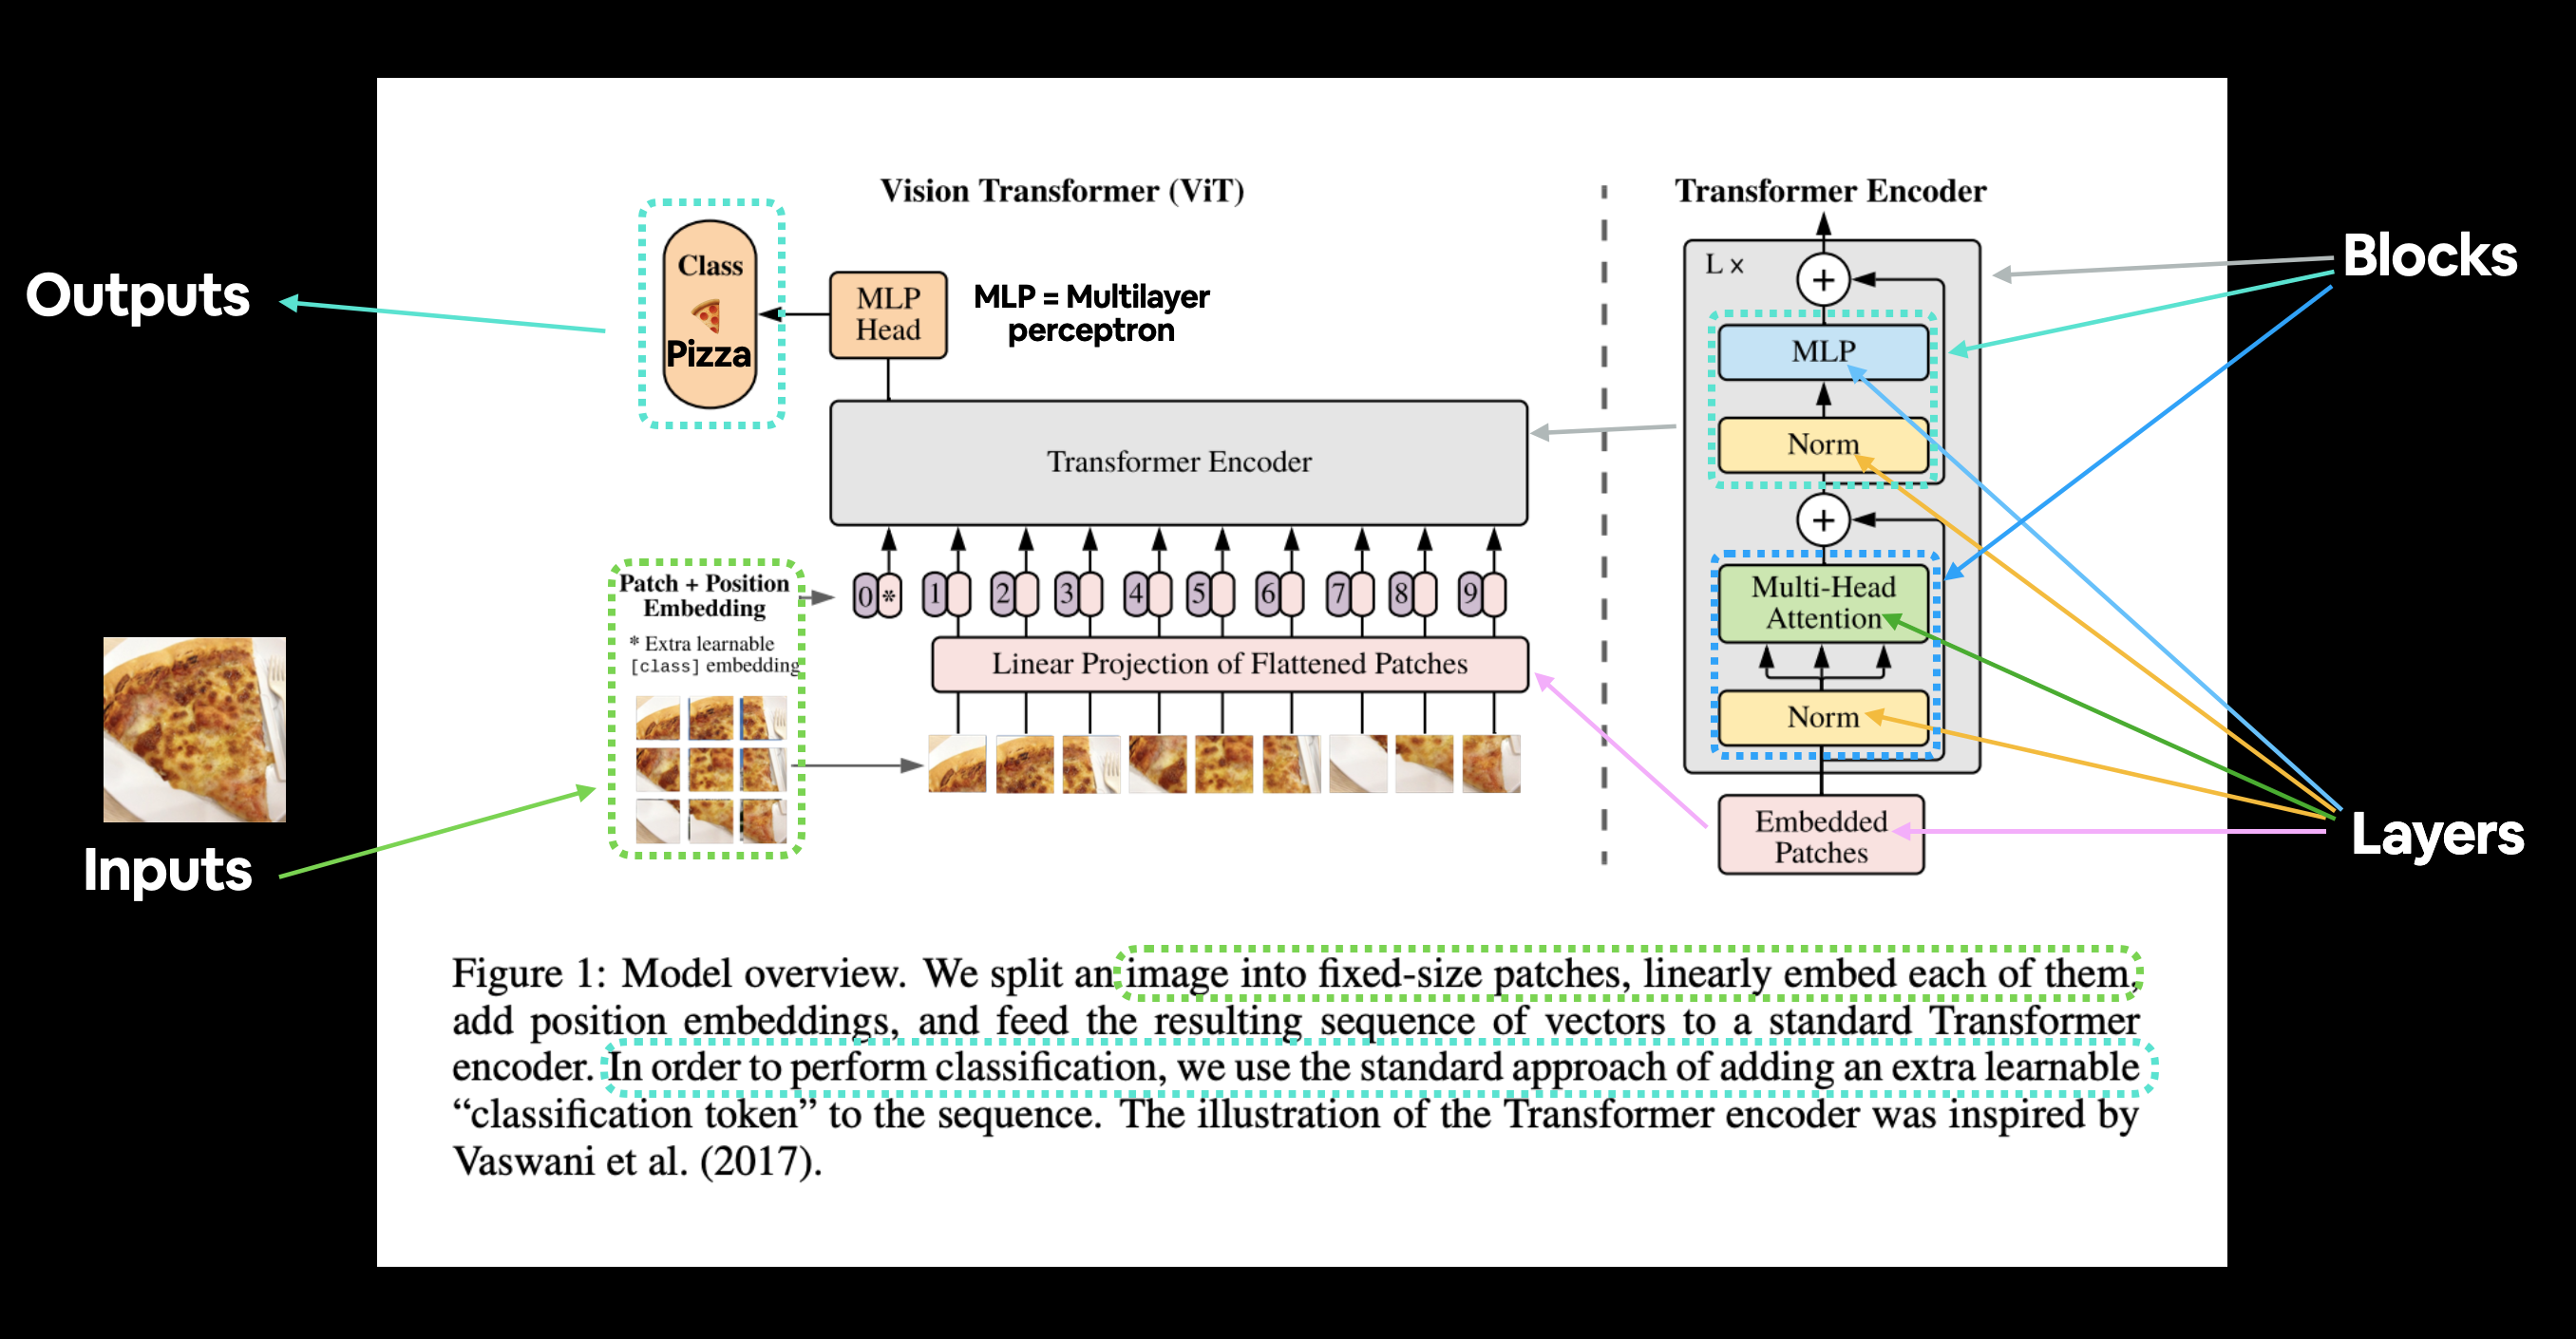

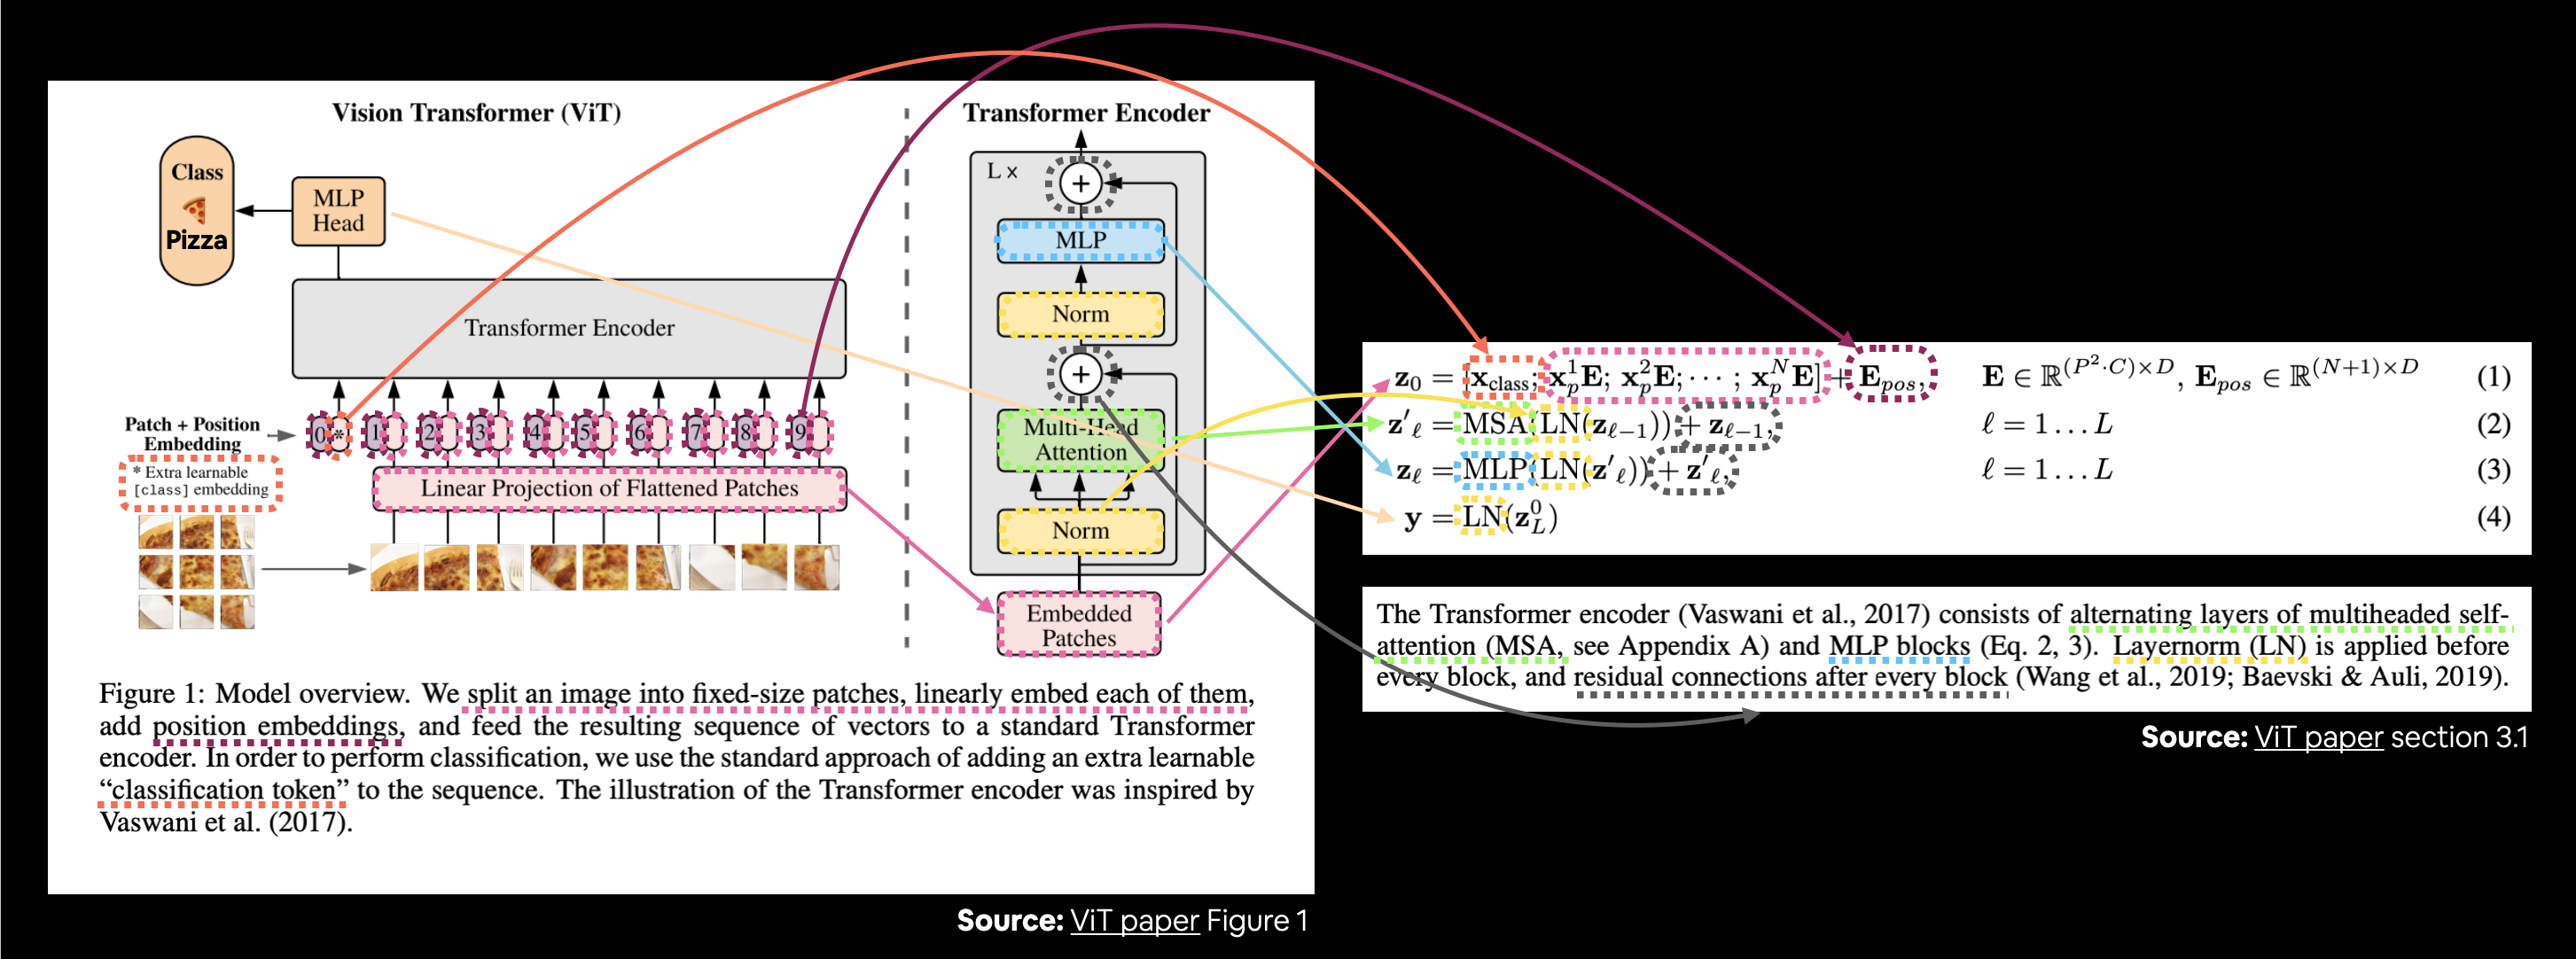

### Patch and position embedding

In [16]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [17]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


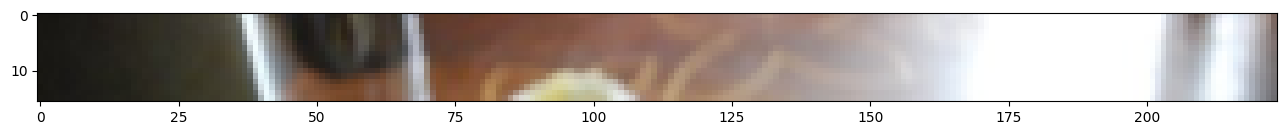

In [10]:
# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


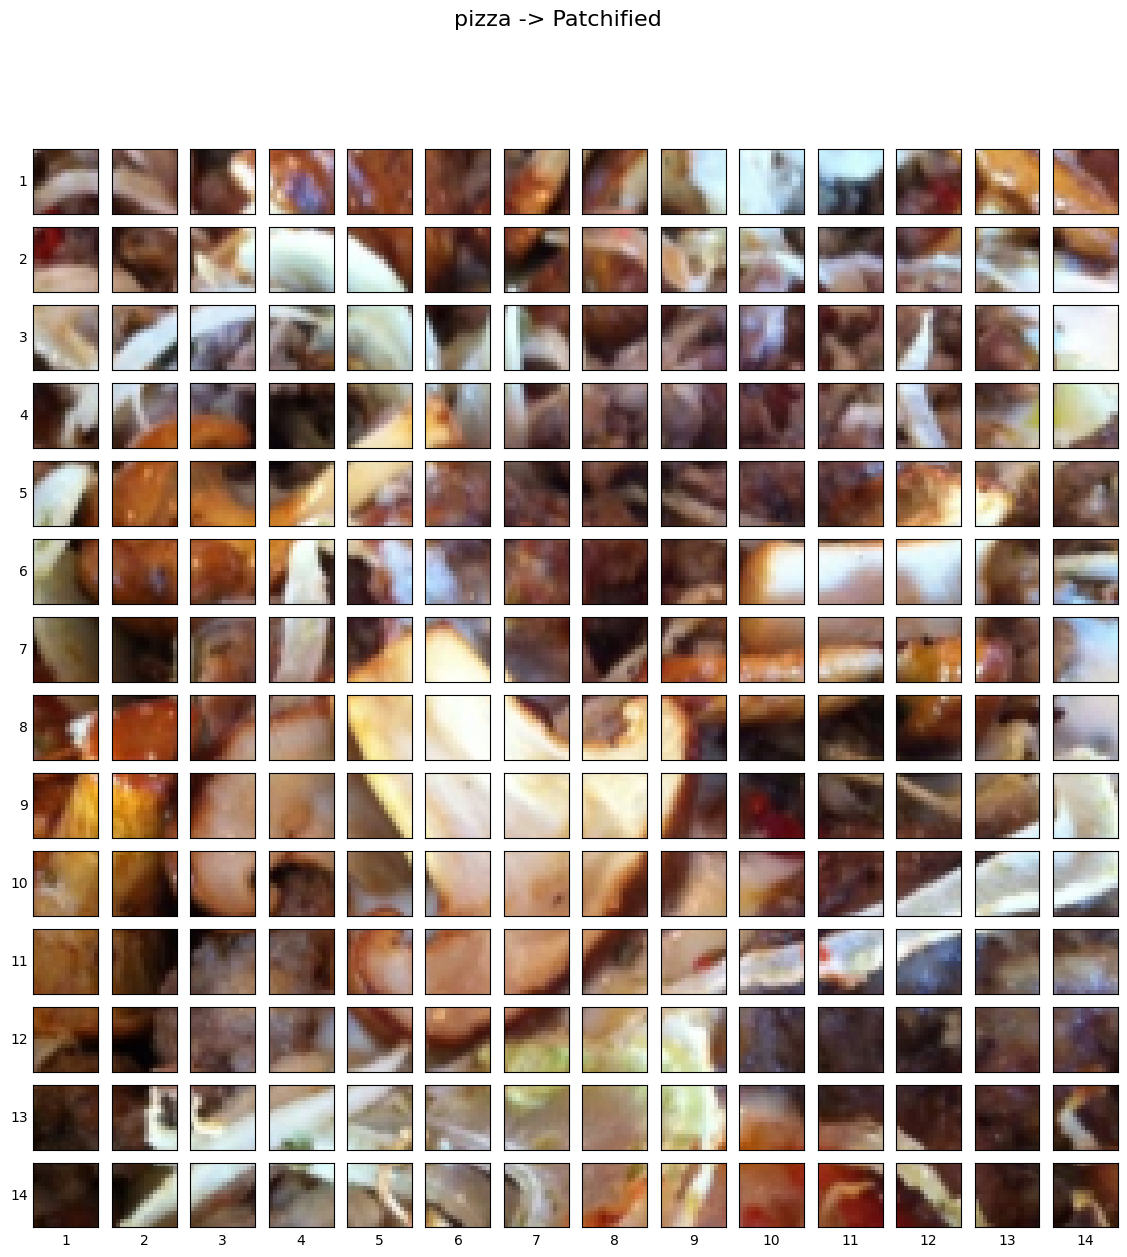

In [ ]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

In [21]:
# @title Conv2d to create patches
from torch import nn

# Set the patch size
patch_size=16

# 224 / 16 = 14 -> exploit the CNN with kernel_size (16,16) and stride 16 to create 14 patches

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # each path is described by a 768-D vector, or we can say that there are 768 activation/feature maps
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)


# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)
# torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [405, 93, 744, 436, 450]


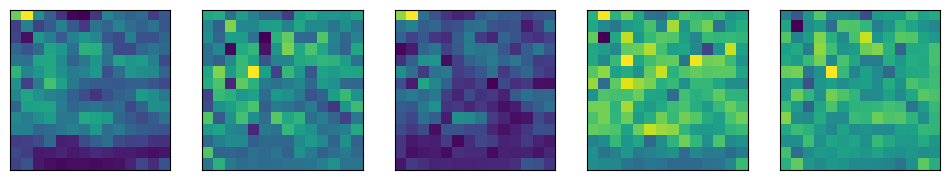

In [20]:
# @title Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

Since a CNN is used to create the embeddings, and the CNN can be trained, then the feature maps can be considered a **learnable embedding** of the image

In [ ]:
# @title Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0220, -0.0178, -0.0169,  0.0196, -0.0112,  0.0207, -0.1855,
            0.0406, -0.0617,  0.0664, -0.1452, -0.0922,  0.0015,  0.0792],
          [ 0.1212, -0.0727,  0.0780,  0.0612,  0.1607,  0.0384, -0.0084,
           -0.0356,  0.0315,  0.0971, -0.0197, -0.0181,  0.2189,  0.0714],
          [ 0.0486,  0.0547,  0.0114, -0.0376,  0.1003,  0.1289,  0.1702,
            0.0526, -0.1284,  0.0110, -0.0701,  0.1145, -0.1108,  0.0779],
          [-0.1619,  0.0296, -0.0778, -0.0133, -0.0040, -0.1491, -0.0918,
           -0.1267, -0.0348,  0.0260,  0.0148,  0.1880,  0.0463,  0.0235],
          [-0.1135, -0.0497,  0.0759,  0.1556,  0.0096,  0.0411,  0.0116,
            0.0094,  0.0427, -0.0184, -0.0583,  0.1377, -0.1703,  0.0602],
          [ 0.1278, -0.0771,  0.0085,  0.0917, -0.0174,  0.0950, -0.0153,
           -0.0507, -0.0349,  0.0082,  0.0148,  0.0514,  0.1302,  0.0266],
          [ 0.0361, -0.0455, -0.0491,  0.0512,  0.0368,  0.1877,  0.0692,
            0.0063,  0.0996,  0.

Notice in fact how `grad_fn` output of a single feature map and `requires_grad = True` mean that PyTorch is keeping track of its gradients in order to update them during training

In [23]:
# @title Create flatten layer to flatten the height and weight of each feature map
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

Flattened image feature map shape: torch.Size([1, 768, 196])


In [26]:
# @title Each patch has a 768-D embedding
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


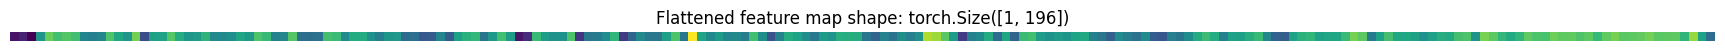

In [27]:
# @title Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [28]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 7.
    """

    def __init__(self,
                 in_channels: int = 3, # C
                 patch_size: int = 16, # P
                 embedding_dim: int = 768): # P^2•C
        super().__init__()

        self.patcher = nn.Conv2d(in_channels = in_channels,
                                 out_channels =  embedding_dim,
                                 kernel_size = patch_size,
                                 stride = patch_size,
                                 padding = 0)
        self.flatten = nn.Flatten(start_dim = 2,
                                  end_dim = 3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size ==0, f"Input image size must be divisible by the patch size"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [29]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [30]:
# @title Summary of PatchEmbedding model

random_input_image = (1, 3, 224, 224)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In BERT, a special token [class] is prepended to the sequence of tokens (words) in a sentence. This token is used to aggregate information from the entire sequence during processing. The final representation of this [class] token after passing through the Transformer layers is used for tasks like classification. <br>It adopts a similar mechanism by introducing a learnable embedding at the start of the sequence of embedded image patches with the same dimension of the patch embeddings (768) <br>
The tensor is made **learnable** by passing it to `nn.Parameter()` with `requires_grad = True`

If the sequence of patch embeddings is denoted as:
[Patch 1], [Patch 2],
…
, [Patch N]

After prepending the class_token, the sequence becomes:

[class_token], [Patch 1], [Patch 2],
…
, [Patch N]


This initial embedding is the same across all images in the batch, meaning it starts off the same regardless of the image it's paired with. By the time the sequence exits the Transformer, the embedding of the class_token has been updated. It now contains a representation that is specific to the image it was paired with, having aggregated information from all the patches. <br>
It's learnable because we want it to be best possible to start modelling a summary of the image, instead of random values

In [31]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad = True)

print(class_token[:, :, :10])

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")


tensor([[[-2.4663,  0.4867,  0.8128,  0.3298, -1.6121, -0.5759, -0.2281,
           0.2943,  0.1197,  1.5855]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [32]:
final_input = torch.cat((class_token, patch_embedded_image),
                        dim = 1)

print(final_input)

print(f"Sequence of patch embeddings with class token preprended has shape: {final_input.shape} --> [batch_size, number_of_patches, embedding_dimensions]")

tensor([[[-2.4663,  0.4867,  0.8128,  ...,  0.9203,  0.2370,  1.4758],
         [-1.1497,  0.4191, -0.1197,  ...,  0.6325, -0.4213,  0.1845],
         [-1.0358,  0.2490, -0.2197,  ...,  0.7152, -0.4912,  0.3468],
         ...,
         [-0.1615,  0.0201, -0.1396,  ...,  0.3176, -0.1571,  0.0926],
         [-0.2831, -0.1428, -0.0744,  ...,  0.1360, -0.0034,  0.2045],
         [-0.5107,  0.0413,  0.0516,  ...,  0.1143, -0.1313,  0.2453]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token preprended has shape: torch.Size([1, 197, 768]) --> [batch_size, number_of_patches, embedding_dimensions]


In [33]:
# @title Add a learnable 1D set of position embeddings

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = final_input.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.randn(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-7.4114e-01,  8.1541e-01, -3.6316e-01,  1.0176e+00,  4.5293e-01,
           9.5421e-01, -1.9018e+00,  9.4062e-02, -1.0380e+00,  8.5705e-01],
         [-6.3292e-01,  6.0168e-01,  7.7370e-01, -6.4148e-01, -1.5129e-02,
          -7.0166e-01, -5.5823e-01,  1.1979e+00,  1.0343e+00, -8.0253e-01],
         [ 4.1812e-01, -8.0315e-01,  6.8380e-01, -6.9289e-01, -3.1867e-01,
          -1.1738e+00, -2.0773e+00,  8.2932e-02, -4.8459e-01,  5.6662e-01],
         [ 9.8222e-01, -2.8216e-01, -8.5354e-01,  9.9346e-02,  4.3550e-02,
           2.0549e-01,  1.7851e+00,  5.2269e-02,  2.8783e-01,  1.2212e+00],
         [ 3.9332e-01, -4.4542e-01, -1.1296e+00,  2.9640e-01,  1.2835e+00,
          -4.3154e-01, -3.4652e-01,  3.9845e+00,  1.7684e+00, -2.0047e-01],
         [-1.0939e+00,  6.1262e-01, -6.9854e-02, -2.3281e-01,  8.0949e-04,
           4.6305e-02, -3.4145e-01, -6.8767e-01, -9.8743e-01,  2.3791e+00],
         [-1.5328e+00, -7.9215e-01, -5.5720e-01,  1.0095e+00, -6.4669e-01,
          -1.2823e+

In [34]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = final_input + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-3.2074,  1.3021,  0.4496,  ...,  2.0919, -0.4471, -0.3826],
         [-1.7827,  1.0208,  0.6540,  ...,  0.2020, -1.5974,  0.6885],
         [-0.6177, -0.5541,  0.4640,  ...,  0.6097,  0.7168, -0.8207],
         ...,
         [-0.3619, -2.7089, -0.6288,  ..., -1.3885,  0.0094,  1.3513],
         [ 0.1507,  0.0599,  0.6968,  ..., -0.1139, -0.6889,  0.1707],
         [-2.2495,  0.7982, -0.9865,  ..., -1.4840, -0.2862,  0.7026]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Things to remember:
1. Both the position encoding and the class token are learnable, this mean that the model will find the best values to represent the first position, the second...
2. Position embeddings are **summed** to the patch embeddings and class token
3. On top of the transformer encoder that takes in input *class_token+position_embedding* there's a MLP for the final output

### Transformer Encoder Block
Now we are inside the transformer encoder block and these are the first 3 steps:
1. Layer Normalization - `torch.nn.LayerNorm()`
    - main parameter is `normalized_shape` to set equal to the dimension size we normalize over
    - it normalizes an input over the *last* dimension
2. Multi-Head Self Attention - `torch.nn.MultiheadAttention()` with parameters:
    - `embed_dim` - the embedding dimension
    - `num_heads` - how many attention heads
    - `dropout` - whether or not to apply dropout to the attention layer
    - `batch_first` - does batch dimension come first <br>
3. Residual connection - add the input to the output

1. The input to an instance of nn.MultiheadAttention are 3 Tensors: query, key, value.
2. These are modified by weights: *query weight* is a matrix that transforms the input *query* tensor, same key and value weights. This is especially necessary when the initial input for query, key and value are the same
3. The attention scores (query*key) pass through a Softmax layer and become attention weights in the attention matrix A
4. Multiply each value vector by the softmax score and then sum up the weighted value vectors to produce the output of the self-attention layer at this position (word)
5. Linear transformation to ensure that the output has the same dimension as the input (since the next sep is a residual connection) and mix information from all the attention heads, since so far these have been isolated. The weights belong to the output weight matrix which is returned as output together with the layer outputs

In [35]:
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block
    """

    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 attn_dropout: float = 0):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                    num_heads = num_heads,
                                                    dropout = attn_dropout,
                                                    batch_first = True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query = x,
                                             key = x,
                                             value = x,
                                             need_weights = False)
        return attn_output

In [36]:
msa_block = MultiheadSelfAttentionBlock()
patched_image_post_msa_block = msa_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_post_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


### MLP
A Multi-layer perceptron is a broad concept that can refer to almost any combination of multiple layers, but it usually follows this pattern:
<br> linear layer -> non-linear -> linear -> non-linear
- Linear (fully-connected or dense) layers - contain learnable weights and biases updated during training
- Activation (non-linear) layers - modify the data without altering their dimensionality or introducing new parameters (weights and biases)

In [37]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 mlp_size: int = 3072, # Hidden units
                 dropout: float = 0.1):
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape = embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features = embedding_dim,
                      out_features = mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features = mlp_size,
                      out_features = embedding_dim), # Notice how the input and output shae stays the same
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(self.layer_norm(x))

In [40]:
mlp_block = MLPBlock(embedding_dim = 768,
                     mlp_size = 3072,
                     dropout = 0.2)

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_post_msa_block)
print(f"Input shape of MLP block: {patched_image_post_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [43]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim: int = 768,
                 num_heads: int = 12,
                 mlp_size: int = 3072,
                 mlp_dropout: float = 0.1,
                 attn_dropout: float = 0):
        super().__init__()

        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim = embedding_dim,
                                                     mlp_size = mlp_size,
                                                     dropout = mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x

In [46]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model = transformer_encoder_block,
        input_size = (1, 197, 768),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### PyTorch's Transformer

a transformer encoder is usually considered as a block because it's composed of multiple layers (MLP, MFA, normalization...)
however in the context of the entire model, which usually comprises a stack of identical encoder block, each "layer" in this
stack is an encoder block

In [48]:
# @title Transformer Encoder Layers

transformer_encoder_layer = nn.TransformerEncoderLayer(d_model = 768, # Hidden size
                                                       nhead = 12,
                                                       dim_feedforward = 3072, # Hidden units
                                                       dropout = 0.1, # Dropout for dense layers
                                                       activation = 'gelu',
                                                       batch_first = True,
                                                       norm_first = True) # Normalize before MSA/MLP layers

Stack several transformer layers:
- `encoder_layer` - the instance of `nn.TrnsformerEncoderLayer` that will be used as building brick
- `num_layers` - number of transformer layers encoder to stack

In [50]:
# @title Transformer Encoder
# Stack several transformer layers

transformer_encoder_stack = nn.TransformerEncoder(transformer_encoder_layer,
                                                  num_layers = 3)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### ViT class

In [60]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__()

        # 3. Make the image size is divisble by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder layers (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run dropout on the embedding of patches(Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # Take the embedding of the class_token
        x = self.classifier(x[:, 0])

        return x

In [57]:
# @title Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


In [55]:
set_seeds()

random_image_tensor = torch.randn(1, 3, 224, 224)
vit = ViT(num_classes = len(class_names))

vit(random_image_tensor)

torch.Size([1, 197, 768])
torch.Size([1, 197, 768])


tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [59]:
summary(model = vit,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 15,
        row_settings = ['var_names'])

torch.Size([32, 197, 768])
torch.Size([32, 197, 768])


Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
ViT (ViT)                                                    [32, 3, 224, 224] [32, 3]         152,064         True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224] [32, 196, 768]  --              True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
│    └─Flatten (flatten)                                     [32, 768, 14, 14] [32, 768, 196]  --              --
├─Dropout (embedding_dropout)                                [32, 197, 768]  [32, 197, 768]  --              --
├─Sequential (transformer_encoder)                           [32, 197, 768]  [32, 197, 768]  --              True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─MultiheadSelfAttentionBlock (msa_block)          [32, 197, 768]  

In [ ]:
from going_modular.going_modular import engine

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Train the model and save the training results to a dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

### Pretrained ViT

In [19]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

device = 'cuda' if torch.cuda.is_available() else 'cpu'

pretrained_vit = torchvision.models.vit_b_16(weights = pretrained_vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [64]:
summary(model = pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [20]:
set_seeds()
pretrained_vit.heads = nn.Linear(in_features = 768, out_features = len(class_names))

In [66]:
summary(model = pretrained_vit,
        input_size = (32, 3, 224, 224),
        col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
        col_width = 20,
        row_settings = ['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [11]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [17]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [21]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847
